# Multiaxial Showcase

In [1]:
import numpy as np

import FLife

### Import multiaxial PSD

In [84]:
#PSD inputs
test_PSD = np.load('data/test_multiaxial_PSD_3D.npy')
test_PSD_biaxial = np.load('data/test_multiaxial_PSD_2D.npy')

#Amplitude spectrum inputs
test_amplitude_spectrum_2D = np.load('data/test_multiaxial_amplitude_spectrum_2D.npy')
test_amplitude_spectrum_3D = np.load('data/test_multiaxial_amplitude_spectrum_3D.npy')


### Define frequency vector

In [85]:
freq=np.arange(0,240,3)
freq[0]= 1e-3

## EquivalentStress class

`FLife.EquivalentStress` supports multiaxial criteria defined in frequency domain. Some criteria require PSD matrix, while others require amplitude spectrum vector.

Currently supported criteria, defined for PSD matrix:
- `max_normal`: Maximum normal stress criterion
- `max_shear`: Maximum shear stress criterion
- `max_normal_and_shear`: Maximum normal and shear stress criterion
- `EVMS`: Equivalent von Misses stress criterion
- `cs`: Carpinteri-Spagnoli criterion
- `multiaxial_rainflow`: Frequency-based multiaxial rainflow criterion (defined for 2D stress states)
- `thermoelastic`: Thermoelasticity-based criterion
- `EVMS_out_of_phase`: EVMS adaptation for out-of-phase components. (defined for 2D stress states)

Criteria, defined for amplitude spectrum vector:
- `liwi`: LiWI approach (linearly vibrating systems using wave interference) (defined for 2D stress states)
- `coin_liwi`: COIN LiWI method (extending `liwi` by introducing complex invariants)

### Input

To create a class instance, an input dictionary must be created, consisting of PSD matrix `PSD` or amplitude spectrum `amplitude_spectrum` (depending on criteria later used) and frequency vector `f`.

For a multiaxial PSD, dictionary with keys `PSD` and `f` is expected. `PSD` should include a matrix with the size of `(f,6,6)`, where `f` is the length of the frequency vector.\
For multi-point multiaxial PSD (full stress response of the whole FEM model) a PSD matrix with the size of `(N,f,6,6)` is expected, where `N` is the number of points or nodes in the sistem

For a multiaxial amplitude spectrum input, dictionary with keys `amplitude_spectrum` and `f` is expected. `amplitude_spectrum` should include an array with the size of `(f,6)` (vector $(\sigma_{xx},\sigma_{yy},\sigma_{zz},\sigma_{xy},\sigma_{xz},\sigma_{yz})$ at every frequency), or `(N,f,6)` for multi-point input.

For 2D planar stress states, 3 dimensions $(\sigma_{xx},\sigma_{yy},\sigma_{xy})$, are used instead of 6: `(N,f,3,3)` for PSD input and `(N,f,3)` for amplitude spectrum input

Test model consists of the PSD matrix `(6x6)` at 80 frequencies and at 4181 nodes. 3D and 2D stress state arrays are provided:

In [86]:
test_PSD.shape

(4181, 80, 6, 6)

In [105]:
test_PSD_biaxial.shape

(4181, 80, 3, 3)

Amplitude spectrums of the same load are also provided:

In [106]:
test_amplitude_spectrum_3D.shape

(4181, 80, 6)

In [107]:
test_amplitude_spectrum_2D.shape

(4181, 80, 3)

Creating an input class:

In [120]:
#PSD input
input_dict = {'PSD': test_PSD_biaxial, 'f': freq}


#amplitude spectrum input
#input_dict = {'amplitude_spectrum': test_amplitude_spectrum_3D[331:335], 'f': freq}

### Instantiate a class object

In [121]:
eqs = FLife.EquivalentStress(input=input_dict,T=1,fs=5000)

## Use multiaxial criterion

Choose one of the available multiaxial criteria and use it to convert the full stress reponse at each frequency and each node to the uniaxial equivalent stress, that can be used for damage estimation

In [122]:
#before using multiaxial criteria:
#if defined with PSD matrix
eqs.multiaxial_psd[0].shape

#if defined with amplitude spectrum vector
#eqs.multiaxial_amplitude_spectrum[0].shape

(4181, 80, 3, 3)

In [123]:
eqs.EVMS()

In [124]:
#after using multiaxial criteria:
eqs.eq_psd_multipoint[0].shape

(4181, 80)

In [125]:
eqs.eq_psd_multipoint[0][0,24]

66.86102139049916

## Select critical point

If using multi-node model, the equivalent stress is calculated at every node. A critical point must be selected in which the damage estimation will be carried out.

### Manual point selection

In [126]:
#method for selecting the critical point manually, no visualization

eqs.select_critical_point(point_index=331)

### GUI point selection

The model mesh must first be defined:

In [127]:
#FLife.visualize.set_mesh(eqs,'data/L_shape.vtk')

Interactive point selection with pyVista GUI is launched by running the following line. On the right side, the model is displayed. By right-clicking on the model, a critical point is selected. At selection, the equivalent PSD is saved to `eqs.psd` and can be later used for damage estimation. At right-click, the equivalent PSD is displayed on the left-hand side. By moving the slider on the bottom-left, the heatmap of the equivalent stress is updated on the model at the frequency, selected with a slider. At each right click on the model, the critical point is updated.

In [128]:
#FLife.visualize.pick_point(eqs)

After point selection, equivalent stress PSD can be displayed together with automatically generated time history:

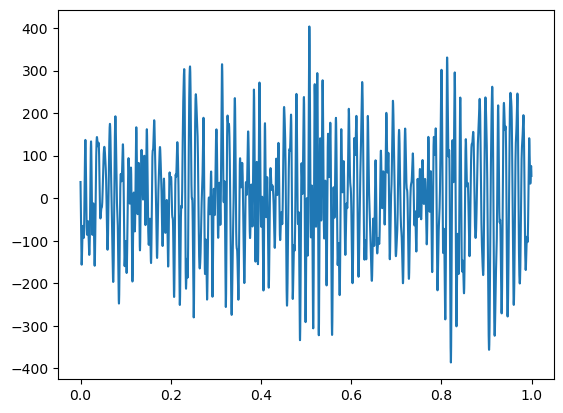

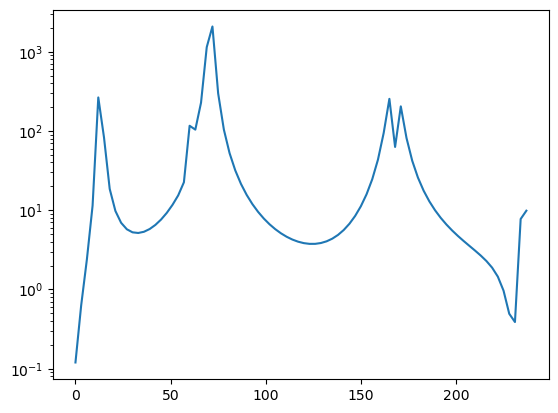

In [129]:
import matplotlib.pyplot as plt

time_history_eqs = eqs.data
time_eqs = np.arange(0, 1, eqs.dt)
plt.plot(time_eqs,time_history_eqs)
#plt.xlim(0,0.05)

plt.figure()
plt.semilogy(eqs.psd[:,0],eqs.psd[:,1])

## Calculate fatigue life

Fatigue life can be estimated using one of the many methods supplied by `FLife`

In [130]:
rf = FLife.TovoBenasciutti(eqs)

In [131]:
C = 1.8e+22
k = 7.3

#fatigue life in seconds
rf.get_life(C=C, k=k)

456.06991585509184